Notebook for exploring properties of network generation models

In [1]:
from scipy.stats.distributions import expon, binom
import networkx as nx
import numpy as np
from math import comb
from enum import Enum
from matplotlib import pyplot as plt
import torinanet as tn
from model import RandomGraphModel, PreferentialAttachmentModel, Distribution

/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


# Compare network properties
Proof goodness of fit of pereferential attachement model by comparing it to known networks

In [2]:
# read data
real_rxngraph = tn.core.RxnGraph.from_file("real.rxn")
real_G = real_rxngraph.to_networkx_graph(use_internal_id=True)

/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


In [4]:
def generate_synthetic_graphs(nspeices, nreactions, ngraphs):
    model = PreferentialAttachmentModel(nspeices, nreactions, specie_energy_dist=expon(1))
    return [model.generate_graph() for _ in range(ngraphs)]

sreal_graphs = generate_synthetic_graphs(real_rxngraph.get_n_species(), real_rxngraph.get_n_reactions(), 10)

In [5]:

class DegreeTypes (Enum):
    IN = lambda g, s: len(list(g.predecessors(s)))
    OUT = lambda g, s: len(list(g.successors(s)))
    TOTAL = lambda g, s: len(list(g.successors(s))) + len(list(g.predecessors(s)))

def get_degrees_of_rxngraph(rxn_graph, G, degree_type: DegreeTypes):
    degrees = []
    for sp in rxn_graph.species:
        k = rxn_graph.specie_collection.get_key(sp)
        degrees.append(degree_type(G, k))
    return degrees

dtype = DegreeTypes.TOTAL
degrees = get_degrees_of_rxngraph(real_rxngraph, real_G, dtype)
sdegrees = []
for g in sreal_graphs:
    sdegrees += [dtype(g, s) for s in g if "s" in s and not s == "s0"]

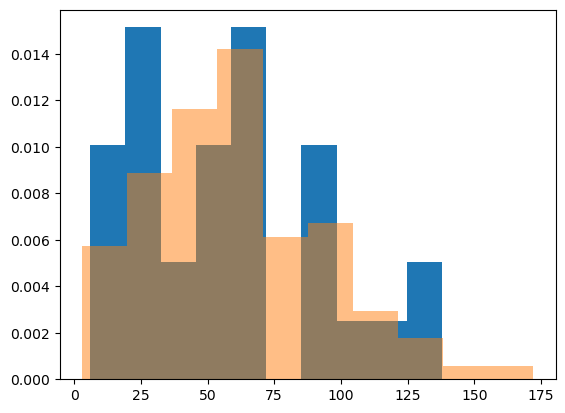

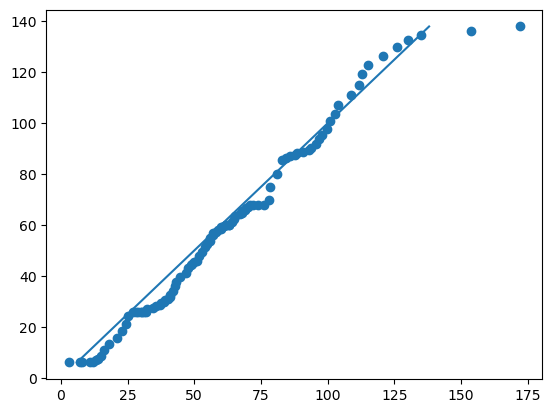

In [6]:
plt.hist(degrees, density=True)
plt.hist(sdegrees, density=True, alpha=0.5)

quantiles = np.linspace(0, 100, 100)
true = np.percentile(degrees, quantiles)
pred = np.percentile(sdegrees, quantiles)
plt.figure()
plt.scatter(pred, true)
plt.plot(true, true)

# Atomization energy distribution
Estimate the distribution of specie atomic energy. using energies from joined database with calculated energies for all calculations.

In [7]:
import sqlite3
from openbabel import openbabel as ob
import pandas as pd

connection = sqlite3.connect("../data/joined.db")

def get_energy(smiles):
    return connection.execute("SELECT energy FROM species WHERE smiles=\"{}\"".format(smiles)).fetchall()[0][0]

def get_atomization_energy(smiles: str, atom_energies: dict):
    # read smiles
    conv = ob.OBConversion()
    conv.SetInFormat("smi")
    obmol = ob.OBMol()
    conv.ReadString(obmol, smiles)
    obmol.AddHydrogens()
    # get single atom energy
    ajr = 0
    for atom in ob.OBMolAtomIter(obmol):
        ajr += atom_energies[ob.GetSymbol(atom.GetAtomicNum())]
    return ajr - get_energy(smiles)


atom_energies = {"H": get_energy("[H]"), "N": get_energy("[N]"), "O": get_energy("[O]"), "C": get_energy("[C]")}
# get_atomization_energy("N[N]", atom_energies)
smiles_strings = connection.execute("SELECT smiles FROM species WHERE successful=1").fetchall()
atomization_energies = [get_atomization_energy(smiles[0], atom_energies) for smiles in smiles_strings]
atomization_energies_df = pd.DataFrame({"smiles": [s[0] for s in smiles_strings], "energy": atomization_energies})

connection.close()

(array([0.02634045, 0.14675394, 0.38005508, 2.00187427, 2.4082698 ,
        2.85229454, 2.63028217, 1.25305288, 0.80150229, 0.25964159]),
 array([-0.15439082, -0.07602133,  0.00234817,  0.08071766,  0.15908716,
         0.23745665,  0.31582614,  0.39419564,  0.47256513,  0.55093463,
         0.62930412]),
 <BarContainer object of 10 artists>)

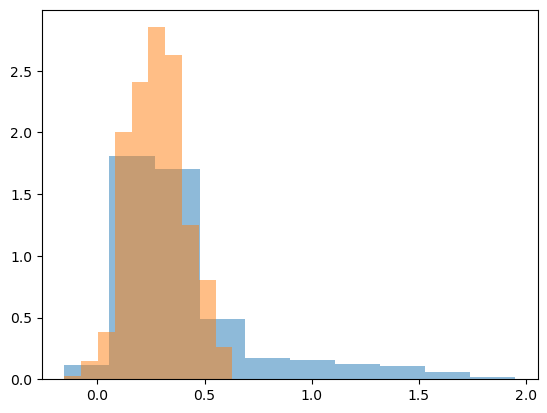

In [8]:
plt.hist(atomization_energies, density=True, alpha=0.5)
plt.hist(atomization_energies_df[~atomization_energies_df["smiles"].str.contains("C")]["energy"], density=True, alpha=0.5)

In [9]:
print(atomization_energies_df["energy"].mean())
print(atomization_energies_df["energy"].std())

0.4076437635274041
0.33297794558844485


0.15104211483582117 0.11131442163222974


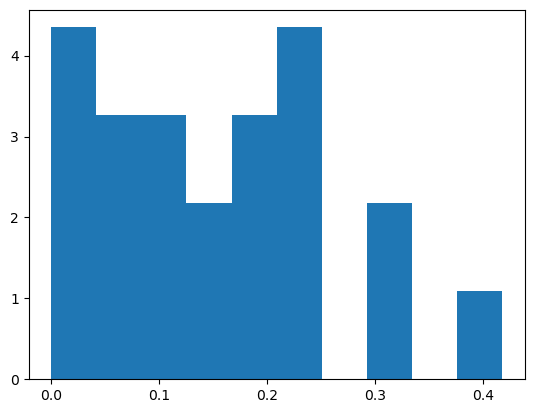

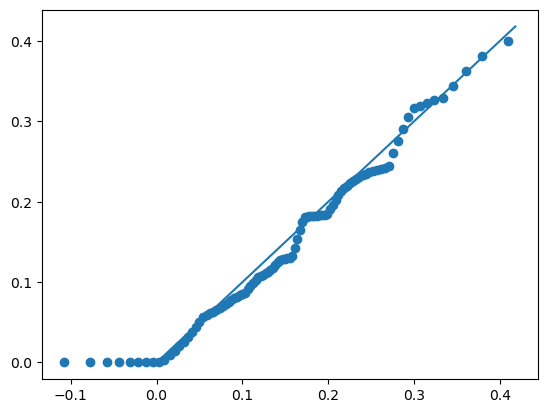

In [10]:
from scipy.stats import norm
energies = []
for s in real_rxngraph.species:
    if s.identifier in atomization_energies_df['smiles'].tolist():
        energies.append(atomization_energies_df[atomization_energies_df["smiles"] == s.identifier]["energy"].values[0])
senergies = []
for g in sreal_graphs:
    senergies += [g.nodes[s]["energy"] for s in g if "s" in s and not s == "s0"]

plt.hist(energies, density=True)
# plt.hist(senergies, density=True, alpha=0.5)

quantiles = np.linspace(0, 100, 100)
true = np.percentile(energies, quantiles)
# m = atomization_energies_df[~atomization_energies_df["smiles"].str.contains("C")]["energy"].mean()
# s = atomization_energies_df[~atomization_energies_df["smiles"].str.contains("C")]["energy"].std()
m = np.mean(energies)
s = np.std(energies)
print(m, s)
pred = [norm(m, s).isf(1 - x / 100) for x in quantiles]
plt.figure()
plt.scatter(pred, true)
plt.plot(true, true)

# Kinetic scaling relations
now we try to check out the scaling relations between reaction energy and max reaction rate

N REACTIONS 78
      T      mean       std       1/T
0   400 -0.719166  4.443108  0.002500
1   600 -0.679247  3.680783  0.001667
2   800 -0.726926  3.280527  0.001250
3  1000 -0.795769  3.037203  0.001000
4  1200 -0.868386  2.882690  0.000833
mean [77.1300649  -0.86973737] 0.47305290164085995
std [937.9531001    2.10483029] 0.9998327647625803


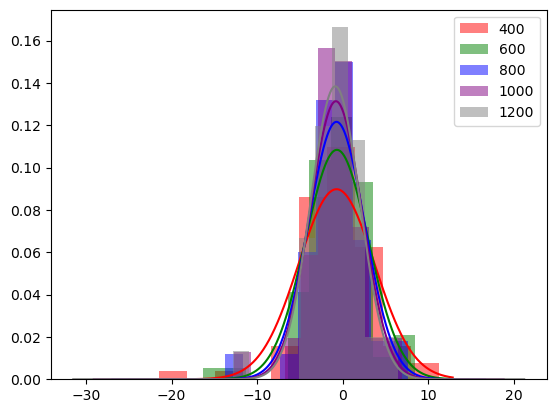

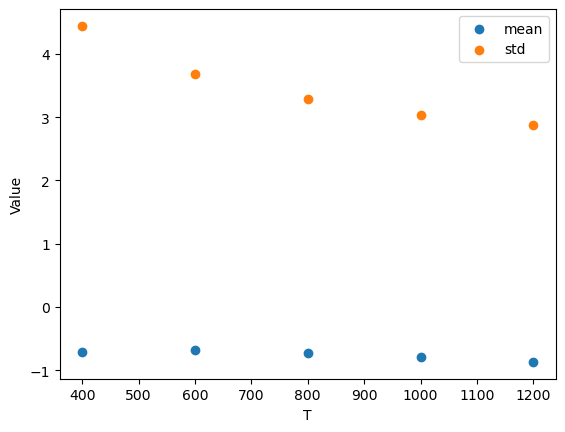

In [49]:
from scipy import stats
df = pd.read_csv("../data/okafor2018_scaling_data.csv", index_col=1)
print("N REACTIONS", len(df))
df = df.drop(columns=["Unnamed: 0"])
# add log k column
R = 8.314
kb = 1.38e-23
h = 6.626e-34

def make_hist(T, c=None, plot=True):
    df["logk_arrhenius"] = np.log(df["A"]) + df["beta"] * np.log(T) - df["Ea"] / (R * T)
    df["logk_eyring"] = np.log(kb / h) + np.log(T) - df["deltaE"] / (R * T)
    x = df["logk_arrhenius"] - df["logk_eyring"]
    if plot:
        dist = stats.norm(np.mean(x), np.std(x))
        plt.hist(x, alpha=0.5, label=T, density=True, color=c)
        xs = np.linspace(*plt.xlim(), num=1000)
        plt.plot(xs, dist.pdf(xs), color=c)
    return x

# make_hist(200)
ajr = []
for T, color in zip([400, 600, 800, 1000, 1200], ["r", "g", "b", "purple", "gray"]):
    r = make_hist(T, c=color, plot=True)
    ajr.append([T, np.mean(r), np.std(r)])

plt.legend()

ajr = pd.DataFrame(ajr, columns=["T", "mean", "std"])
ajr["1/T"] = 1 / ajr["T"]
print(ajr)
plt.figure()
plt.scatter(ajr["T"], ajr["mean"], label="mean")
plt.scatter(ajr["T"], ajr["std"], label="std")
print("mean", np.polyfit(ajr["1/T"], ajr["mean"], deg=1), stats.pearsonr(ajr["1/T"], ajr["mean"]).statistic ** 2)
print("std", np.polyfit(ajr["1/T"], ajr["std"], deg=1), stats.pearsonr(ajr["1/T"], ajr["std"]).statistic ** 2)
plt.xlabel("T")
plt.ylabel("Value")
plt.legend()


In [2]:
class DegreeTypes (Enum):
    IN = lambda g, s: len(list(g.predecessors(s)))
    OUT = lambda g, s: len(list(g.successors(s)))
    TOTAL = lambda g, s: len(list(g.successors(s))) + len(list(g.predecessors(s)))

def get_degrees(g: nx.DiGraph, how: DegreeTypes):
    """Return the degrees of all species in a graph"""
    return [how(g, s) for s in g if "s" in s and not s == "s0"]

def get_energies(g: nx.DiGraph, nreactants: int=None, nproducts: int=None):
    energies = []
    for node in g:
        if "r" in node:
            p = len([x for x in g.successors(node) if not x == "s0"])
            r = len([x for x in g.predecessors(node) if not x == "s0"])
            e = g.nodes[node]["energy"]
            if (p is None and r is None) or (p == nproducts and r == nreactants):
                energies.append(e)
    return energies

def make_histogram(ax, degrees, title, analytic_formula=None, alpha=1):
    ax.hist(degrees, density=True, alpha=alpha)
    if analytic_formula is not None:
        mind, maxd = ax.get_xlim()
        xs = range(int(round(mind)), int(round(maxd)))
        ys = [analytic_formula(d) for d in xs]
        ax.plot(xs, ys, "r--")
    ax.set_title(title)

def specie_degree_distribution(model, nreps: int, alpha: float):
    g = model.generate_graph()
    fig, axs = plt.subplots(ncols=3)
    plt.tight_layout()
    make_histogram(axs[0], get_degrees(g, DegreeTypes.IN), "Created Degree", alpha=alpha, analytic_formula=model.in_degree)
    make_histogram(axs[1], get_degrees(g, DegreeTypes.OUT), "Consumed Degree", alpha=alpha, analytic_formula=model.out_degree)
    make_histogram(axs[2], get_degrees(g, DegreeTypes.TOTAL), "Total Degree", alpha=alpha, analytic_formula=model.total_degree)
    for rep in range(nreps - 1):
        g = model.generate_graph()
        make_histogram(axs[0], get_degrees(g, DegreeTypes.IN), "Created Degree", alpha=alpha)
        make_histogram(axs[1], get_degrees(g, DegreeTypes.OUT), "Consumed Degree", alpha=alpha)
        make_histogram(axs[2], get_degrees(g, DegreeTypes.TOTAL), "Total Degree", alpha=alpha)

def reaction_energy_distribution(model, nreps: int, alpha: float):
    fig, axs = plt.subplots(nrows=2, ncols=2)
    plt.tight_layout()
    for rep in range(nreps):
        g = model.generate_graph()
        for r in range(2):
            for p in range(2):
                f = model.reaction_energy_distribution(r + 1, p + 1).ppf if rep == nreps - 1 else None
                make_histogram(axs[r, p], get_energies(g, r + 1, p + 1), "R{}P{}".format(r + 1, p + 1), alpha=alpha, analytic_formula=f)

explore the wellness of the analytic expressions of the degree distributions

AttributeError: 'PreferentialAttachmentModel' object has no attribute 'reaction_energy_distribution'

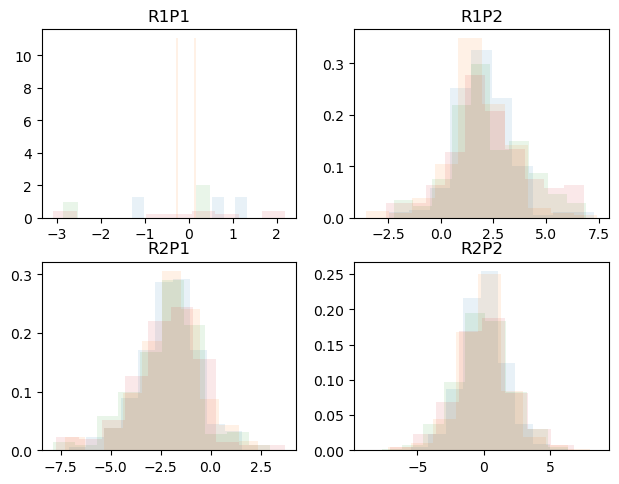

In [5]:
model = PreferentialAttachmentModel(100, 10000, alpha=1, specie_energy_dist=expon(1.065), max_energy=None)
# specie_degree_distribution(model, 5, 0.1)
# plt.figure()
reaction_energy_distribution(model, 5, 0.1)
# net = model.generate_graph()
# degrees = get_degrees(net, DegreeTypes.OUT)
# p = 2 / (model.n_species + 1)
# f = lambda degree: binom(model.n_reactions, p).pmf(degree)
# make_degree_histogram(plt.gca(), degrees, "", analytic_formula=f)

In [3]:
G = model.generate_graph()

NameError: name 'model' is not defined

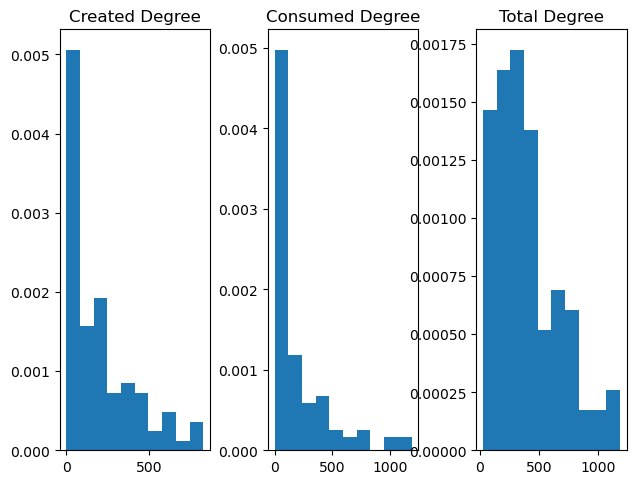

In [8]:
model = PreferentialAttachmentModel(100, 10000, alpha=1, specie_energy_dist=expon(1.065), max_energy=0.15)
# model = RandomGraphModel(100, 10000, specie_energy_dist=expon(1.065), max_energy=None)
G = model.generate_graph()
fig, axs = plt.subplots(ncols=3)
plt.tight_layout()
make_histogram(axs[0], get_degrees(G, DegreeTypes.IN), "Created Degree")
make_histogram(axs[1], get_degrees(G, DegreeTypes.OUT), "Consumed Degree")
make_histogram(axs[2], get_degrees(G, DegreeTypes.TOTAL), "Total Degree")

In [14]:
def empirical_quantiles(data, quantiles: np.ndarray):
    """Compute empirical quantiles from the data."""
    return np.percentile(data, quantiles)

def qq_plot(data, inverse_cdf, quantiles):
    """Generate a Q-Q plot comparing the data to a theoretical distribution."""
    empirical_q = empirical_quantiles(data, quantiles)
    theoretical_q = np.array([inverse_cdf(p / 100.0) for p in quantiles])
    plt.scatter(theoretical_q, empirical_q)
    plt.plot([theoretical_q[0], theoretical_q[-1]], [theoretical_q[0], theoretical_q[-1]], 'k')
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Empirical Quantiles")

# model = Model(100, 10000, expon(1.065), max_energy=None)
# net = model.generate_graph()
# degrees = get_degrees(net, DegreeTypes.TOTAL)
# icdf = binom(model.n_reactions, 4 / (model.n_species + 1)).ppf
# qq_plot(degrees, icdf, np.linspace(20, 80, 100))


In [21]:
import torinanet as tn

rxn_graph = tn.core.RxnGraph.from_file("real.rxn")

/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


In [22]:
print(rxn_graph.get_n_reactions(), rxn_graph.get_n_species())

470 30


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


[46, 68, 60, 132, 58, 30, 88, 106, 60, 138, 120, 96, 68, 56, 64, 66, 52, 26, 86, 26, 32, 6, 16, 26, 28, 38, 8, 6, 90, 44]


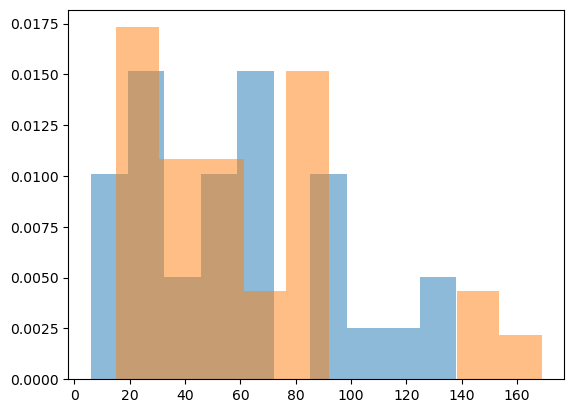

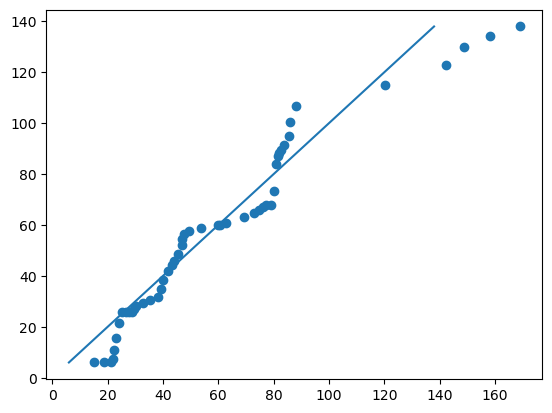

In [25]:
G = rxn_graph.to_networkx_graph(use_internal_id=True)
degrees = []
for sp in rxn_graph.species:
    k = rxn_graph.specie_collection.get_key(sp)
    degrees.append(len(list(G.successors(k))) + len(list(G.predecessors(k))))
    # degrees.append(len(list(G.successors(k))))
print(degrees)
model = PreferentialAttachmentModel(rxn_graph.get_n_species(), rxn_graph.get_n_reactions(), alpha=1, specie_energy_dist=expon(1.065), max_energy=0.15)
predG = model.generate_graph()
pred_degrees = get_degrees(predG, DegreeTypes.TOTAL)
make_histogram(plt.gca(), degrees, "", alpha=0.5)
make_histogram(plt.gca(), pred_degrees, "", alpha=0.5)
# plt.figure()
# icdf = binom(model.n_reactions, 4 / (model.n_species + 1)).ppf
pred_quantiles = empirical_quantiles(pred_degrees, np.linspace(0, 100, 50))
true_quantiles = empirical_quantiles(degrees, np.linspace(0, 100, 50))
plt.figure()
plt.scatter(pred_quantiles, true_quantiles)
plt.plot(true_quantiles, true_quantiles)

# ! Experimental part !

In [5]:
from scipy.integrate import quad
from time import time

def add(f1, f2):
    return lambda t: quad(lambda tau: f1(tau) * f2(t - tau), a=0, b=t)[0]

def difference(f1, f2, max_v):
    return lambda t: quad(lambda tau: f1(tau) * f2(tau - t), a=t, b=max_v)[0]

# se = expon(1) # specie energy dist
# f = se.pdf
# max_v = se.isf(1e-6) # max value is the value above 1 - 1e-6 of values
# print(max_v)
# grid = np.linspace(-max_v, max_v, 100)
# t = time()
# add(f, f) (1)
# difference(add(f, f), f, max_v) (1)
# print(time() - t)
# # ajr = difference(add(f, f), add(f, f), max_v)
# # res = []
# # for i, x in enumerate(grid):
# #     print("point", i + 1, "out of", len(grid))
# #     res.append(ajr(x))
# # plt.plot(grid, res)


In [17]:
from scipy.stats import rv_continuous, rv_discrete
from scipy.signal import fftconvolve

class Distribution:

    def __init__(self, points, pdf):
        self.points = points
        self.pdf = pdf / np.trapz(pdf, points)

    def from_cont_dist(base_dist: rv_continuous, npoints: int=10000, th: float=1e-6):
        base_dist = base_dist
        max_v = base_dist.isf(th)
        X = np.linspace(-max_v, max_v, npoints)
        pdf = base_dist.pdf(X)
        return Distribution(X, pdf)
    
    def from_discrete_dist(base_dist: rv_discrete, min_val: int, max_val: int, *args):
        base_dist = base_dist
        X = np.array(range(min_val, max_val + 1))
        pdf = base_dist.pmf(X, *args)
        return Distribution(X, pdf)
    
    @staticmethod
    def add(dist1, dist2):
        """Computes the PDF of the sum of two distributions via convolution"""
        dx = dist1.points[1] - dist1.points[0]
        xmin = dist1.points[0] + dist2.points[0]
        xmax = dist1.points[-1] + dist2.points[-1]
        pdf_result = fftconvolve(dist1.pdf, dist2.pdf, mode='full') * dx
        new_x = np.linspace(xmin, xmax, len(pdf_result))
        return Distribution(new_x, pdf_result)
    
    @classmethod
    def substract(cls, dist1, dist2):
        """Compute the pdf of the difference of two distributions via convolution"""
        dx = dist1.points[1] - dist1.points[0]
        xmin = dist1.points[0] - dist2.points[-1]
        xmax = dist1.points[-1] - dist2.points[0]
        # we flip the PDF to use convolution also for substraction
        pdf_result = fftconvolve(dist1.pdf, dist2.pdf[::-1], mode='full') * dx
        new_x = np.linspace(xmin, xmax, len(pdf_result))
        return Distribution(new_x, pdf_result)
    
    def cdf(self, v: float) -> float:
        """calculate the CDF of the distribution"""
        # find index of closest point
        i = np.argmin([abs(a - v) for a in self.points])
        # calculate integral up to the closest point
        return np.trapz(self.pdf[:i], self.points[:i])
    
    def cdfvec(self):
        """calculate the CDF of the distribution. returns a vector of CDF values over all definition range"""
        dx = self.points[1] - self.points[0]  # Step size
        cdf_values = np.cumsum(self.pdf) * dx  # Numerical integration
        cdf_values /= cdf_values[-1]
        return cdf_values
    
    def ppf(self, v: float) -> float:
        """calculate the PPF (equivalent to PDF) of the distribution"""
        # find index of closest point
        i = np.argmin([abs(a - v) for a in self.points])
        # calculate integral up to the closest point
        return self.pdf[i]
    
    def __add__(self, other):
        if not isinstance(other, Distribution):
            raise ValueError("Can only add distribution to another distribution")
        return self.add(self, other)
    
    def __sub__(self, other):
        if not isinstance(other, Distribution):
            raise ValueError("Can only substract distribution to another distribution")
        return self.substract(self, other)
    
    def __mul__(self, other):
        if not (type(other) is float or type(other) is int):
            raise ValueError("Can only multiply distribution by a scalar value")
        new_x = self.points * other
        new_pdf = self.pdf / abs(other)
        return Distribution(new_x, new_pdf)


In [58]:
from scipy.interpolate import interp1d

def energy_dist(base_dist: rv_continuous, r: int, p: int, npoints: int=100000, th: float=1e-4) -> Distribution:
    """Return the energy distribution of reaction with r reactants and p products"""
    ajr = Distribution.from_cont_dist(base_dist, npoints, th)
    dist = None
    for _ in range(p):
        if dist is None:
            dist = ajr
        else:
            dist += ajr
    for _ in range(r):
        if dist is None:
            dist = ajr * -1
        else:
            dist -= ajr
    return dist

def reactant_energy_factor(base_dist: rv_continuous, r: int, p: int, max_energy: float, npoints: int=100000, th: float=1e-4):
    edist = energy_dist(base_dist, r - 1, p, npoints, th)
    cdf = edist.cdfvec()
    interp_cdf = interp1d(edist.points, cdf, kind="linear", fill_value=(0, 1), bounds_error=False)
    x_transformed = max_energy + edist.points
    transformed_cdf = interp_cdf(x_transformed)
    base_e = Distribution.from_cont_dist(base_dist, npoints, th)
    tpdf = interp1d(base_e.points, base_e.pdf, fill_value=0, bounds_error=False) (edist.points)
    return np.trapz(transformed_cdf * tpdf, edist.points)


def product_energy_factor(base_dist: rv_continuous, r: int, p: int, max_energy: float, npoints: int=100000, th: float=1e-4):
    edist = energy_dist(base_dist, r, p - 1, npoints, th)
    cdf = edist.cdfvec()
    interp_cdf = interp1d(edist.points, cdf, kind="linear", fill_value=(0, 1), bounds_error=False)
    x_transformed = max_energy - edist.points
    transformed_cdf = interp_cdf(x_transformed)
    base_e = Distribution.from_cont_dist(base_dist, npoints, th)
    tpdf = interp1d(base_e.points, base_e.pdf, fill_value=0, bounds_error=False) (edist.points)
    return np.trapz(transformed_cdf * tpdf, edist.points)


def reaction_fraction(p: int, r: int, nspecies: int):
    if r == 1 and p == 1:
        return 2 / (nspecies * (nspecies + 1))
    elif r == 2 and p == 1:
        return 2 / (nspecies + 1)
    elif r == 1 and p == 2:
        return (2 * (nspecies - 2)) / (nspecies * (nspecies + 1))
    elif r == 2 and p == 2:
        return (nspecies - 3) / (nspecies + 1)
    else:
        return 0
    
class IdealDegreeTypes (Enum):

    OUT = lambda n, r, p: r / (n - r + 1)
    IN = lambda n, r, p: p / (n - r - p + 1)
    TOTAL = lambda n, r, p: (r + p) / (n - r - p + 1)

    
def degree_distribution(model: Model, t=IdealDegreeTypes) -> Distribution:
    ajr = None
    for r in range(1, 3):
        for p in range(1, 3):
            efactor = reactant_energy_factor(model.specie_energy_dist, r, p, model.max_energy)
            print("r{}p{}".format(r, p), efactor, t(model.n_species, r, p), reaction_fraction(p, r, model.n_species))
            prob = efactor * t(model.n_species, r, p) * reaction_fraction(p, r, model.n_species)
            dist = Distribution.from_discrete_dist(binom(model.n_reactions, prob), 0, model.n_reactions)
            if ajr is None:
                ajr = dist
            else:
                ajr += dist
    return ajr

In [59]:
import pandas as pd
xs = [-1, -0.5, 0, 0.5, 1, 10]
data = []
for max_e in xs:
    data.append([reactant_energy_factor(expon(scale=1), 1, 1, max_e), reactant_energy_factor(expon(scale=1), 1, 2, max_e), reactant_energy_factor(expon(scale=1), 2, 1, max_e), reactant_energy_factor(expon(scale=1), 2, 2, max_e)])
df = pd.DataFrame(data, index=xs, columns=["r1p1", "r1p2", "r2p1", "r2p2"])
df


,r1p1,r1p2,r2p1,r2p2
-1.0,0.183893,0.091906,0.459813,0.275837
-0.5,0.303254,0.151592,0.606541,0.379054
0.0,0.500046,0.249998,0.750048,0.500023
0.5,0.696802,0.393515,0.848436,0.620988
1.0,0.816140,0.540238,0.908111,0.724197
10.0,1.000000,0.999843,1.000000,0.999927


r1p1 0.3032241831181765
r1p2 0.15167625520312442
r2p1 0.6065796746647546
r2p2 0.37911589820347336


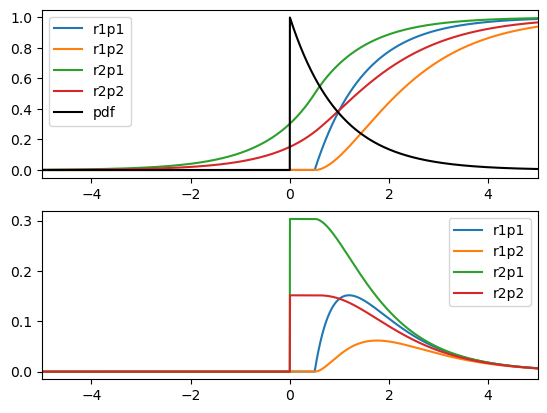

In [60]:
def transformed_cdf(edist, max_e):
    cdf = edist.cdfvec()
    interp_cdf = interp1d(edist.points, cdf, kind="linear", fill_value=(0, 1), bounds_error=False)
    x_transformed = max_e + edist.points
    transformed_cdf = interp_cdf(x_transformed)
    return transformed_cdf

fig, axs = plt.subplots(nrows=2)
max_e = -0.5
base_dist = Distribution.from_cont_dist(expon(scale=1))
for r in range(1, 3):
    for p in range(1, 3):
        edist = energy_dist(expon(scale=1), r-1, p)
        tcdf = transformed_cdf(edist, max_e)
        axs[0].plot(edist.points, tcdf, label="r{}p{}".format(r, p))
        interp_pdf = interp1d(base_dist.points, base_dist.pdf, kind="linear", fill_value=0, bounds_error=False)
        pdf = interp_pdf(edist.points)
        axs[1].plot(edist.points, tcdf * pdf, label="r{}p{}".format(r, p))
        print("r{}p{}".format(r, p), np.trapz(tcdf * pdf, edist.points))
axs[0].plot(base_dist.points, base_dist.pdf, label="pdf", color="k")
axs[0].set_xlim(-5, 5)
axs[0].legend()
axs[1].set_xlim(-5, 5)
axs[1].legend()

r1p1 0.5476372970355726 0.01 0.00019801980198019803
r1p2 0.09518932675688832 0.01 0.019405940594059406
r2p1 0.9220996750231139 0.020202020202020204 0.019801980198019802
r2p2 0.5249959153801032 0.020202020202020204 0.9603960396039604


(0.0, 1000.0)

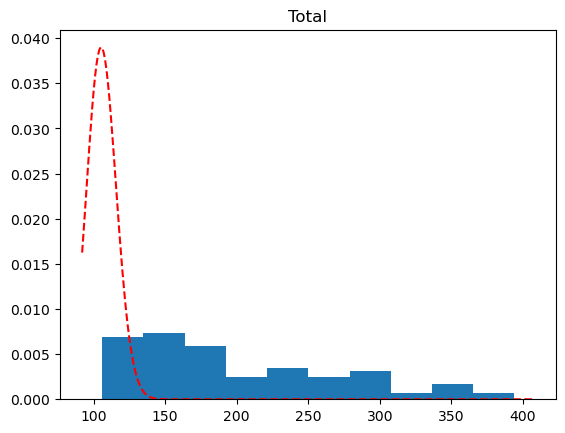

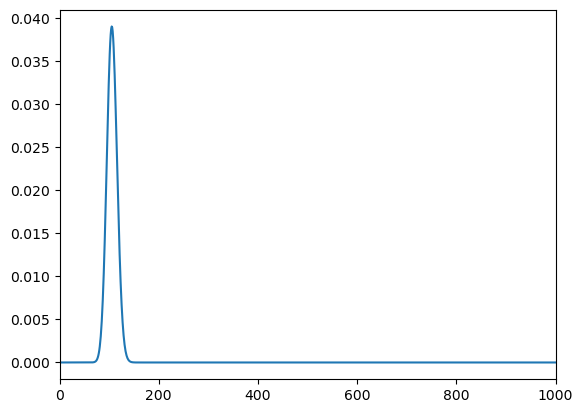

In [61]:
model = Model(100, 10000, expon(1.065), max_energy=0.1)
net = model.generate_graph()
degrees = get_degrees(net, DegreeTypes.OUT)
ideal = degree_distribution(model, IdealDegreeTypes.OUT)
make_histogram(plt.gca(), degrees, "Total", ideal.ppf)
plt.figure()
plt.plot(ideal.points, ideal.pdf)
plt.xlim(0, 1000)


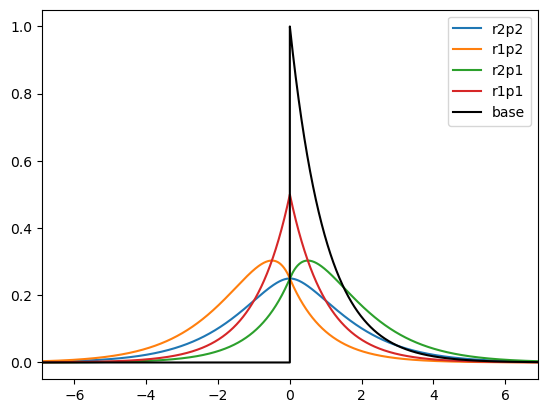

In [53]:
base_dist = expon(scale=1)
dist = Distribution.from_cont_dist(base_dist, npoints=100000)

r2p2 = (dist + dist) - (dist + dist)
plt.plot(r2p2.points, r2p2.pdf, label="r2p2")
r1p2 = (dist) - (dist + dist)
plt.plot(r1p2.points, r1p2.pdf, label="r1p2")
r2p1 = (dist + dist) - (dist)
plt.plot(r2p1.points, r2p1.pdf, label="r2p1")
r1p1 = (dist) - (dist)
plt.plot(r1p1.points, r1p1.pdf, label="r1p1")
plt.plot(dist.points, dist.pdf, label="base", color="k")
v = base_dist.isf(1e-3)
plt.xlim(-v, v)
plt.legend()


(-6.907755278982137, 6.907755278982137)

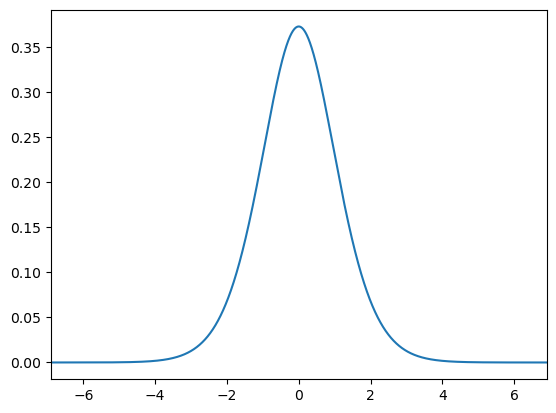

In [11]:
N = 100
total = r1p1 * (2 / (N * (N + 1))) + r2p1 * (2 / (N + 1)) + r1p2 * 2 * ((N - 2) / (N * (N + 1))) + r2p2 * ((N - 3) / (N + 1))
plt.plot(total.points, total.pdf, label="total")
plt.xlim(-v, v)
